In [6]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from algorithms.score_based import *
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum
%load_ext autoreload
%autoreload 2

In [7]:
from collections.abc import Iterable


In [8]:
def reference_score(x):
    if isinstance(x, (int, float)):
        return np.array([-x]).reshape(-1, 1)
    return -x.reshape(-1, 1)

In [9]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau <= 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau)
        else:
            not_detected +=1

    if not_detected == runs:
        return 0, 0, 0, not_detected

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

## Univariate mean shift 

### Score-based change point detector
linear $\Psi$, $\eta=1/\sqrt{t}$

In [5]:
def train_params(lambda_list, alpha_list, thrs_add=0):
    n = 300
    tau = 150
    runs = 10
    sigma = 0.2
    eta = 1 / np.sqrt(np.arange(1, n+1))
    dim = 1

    np.random.seed(3)
    for l in lambda_list:
        for a in alpha_list:
            # threshold 
            S_0 = np.empty(0)
            for item in range(10):
                X = sigma * randn(size=tau).reshape((tau, dim, 1))                
                model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                S, _ = model.run(X, eta, recalc=True)
                S_0 = np.append(S_0, S)
            threshold = np.round(np.max(S_0), 4)
            print('threshold = ', threshold)


            S_list = np.empty((runs, n))
            for item in range(runs):
                X = sigma * randn(size=n).reshape((n, dim, 1))      
                X[tau:] += 2*sigma          
                model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S

            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list

In [22]:
S = train_params([1.1], [1e-3])
S = train_params([1.1,], [4e-3])
S = train_params([1.1], [ 6e-3])
S = train_params([1.2], [1e-3])
S = train_params([1.2,], [4e-3])
S = train_params([1.2], [ 6e-3])

threshold =  0.0119
lambda = 1.1, alpha = 0.001  False alarms: 0 DD :  11.3 ± 3.5 not detected:  0
threshold =  0.0205
lambda = 1.1, alpha = 0.004  False alarms: 0 DD :  8.4 ± 3.3 not detected:  0
threshold =  0.0256
lambda = 1.1, alpha = 0.006  False alarms: 0 DD :  8.2 ± 3.5 not detected:  0
threshold =  0.0108
lambda = 1.2, alpha = 0.001  False alarms: 0 DD :  11.1 ± 3.4 not detected:  0
threshold =  0.0194
lambda = 1.2, alpha = 0.004  False alarms: 0 DD :  8.3 ± 3.4 not detected:  0
threshold =  0.0245
lambda = 1.2, alpha = 0.006  False alarms: 0 DD :  7.9 ± 3.3 not detected:  0


In [24]:
S = train_params([1], [1e-2])
S = train_params([1.1,], [1e-2])
S = train_params([1.3], [ 1e-2])
S = train_params([1.4], [1e-2])


threshold =  0.036
lambda = 1, alpha = 0.01  False alarms: 0 DD :  7.3 ± 3.4 not detected:  0
threshold =  0.0346
lambda = 1.1, alpha = 0.01  False alarms: 0 DD :  7.3 ± 3.4 not detected:  0
threshold =  0.0324
lambda = 1.3, alpha = 0.01  False alarms: 0 DD :  7.3 ± 3.6 not detected:  0
threshold =  0.0315
lambda = 1.4, alpha = 0.01  False alarms: 0 DD :  7.3 ± 3.6 not detected:  0



In [25]:
S = train_params([1.5,], [1e-3])
S = train_params([1.5,], [5e-3])
S = train_params([1.5,], [1e-2])

S = train_params([10], [1e-5])
S = train_params([10], [1e-4])
S = train_params([10], [1e-3])
S = train_params([10], [1e-2])

threshold =  0.0086
lambda = 1.5, alpha = 0.001  False alarms: 0 DD :  10.3 ± 3.4 not detected:  0
threshold =  0.0196
lambda = 1.5, alpha = 0.005  False alarms: 0 DD :  7.7 ± 3.8 not detected:  0
threshold =  0.0307
lambda = 1.5, alpha = 0.01  False alarms: 0 DD :  7.2 ± 3.7 not detected:  0
threshold =  0.0002
lambda = 10, alpha = 0.0  False alarms: 0 DD :  35.5 ± 13.9 not detected:  0
threshold =  0.0004
lambda = 10, alpha = 0.0001  False alarms: 0 DD :  14.4 ± 7.7 not detected:  0
threshold =  0.0019
126 7
lambda = 10, alpha = 0.001  False alarms: 1 DD :  10.8 ± 7.8 not detected:  0
threshold =  0.0125
101 4
125 7
lambda = 10, alpha = 0.01  False alarms: 2 DD :  12.5 ± 7.6 not detected:  0


In [7]:
S = train_params([1.6,], [1e-2])
S = train_params([1.7,], [1e-2])
S = train_params([1.8,], [1e-2])
S = train_params([1.9,], [1e-2])
S = train_params([2,], [1e-2])

threshold =  0.0299
126 7
lambda = 1.6, alpha = 0.01  False alarms: 1 DD :  7.6 ± 3.7 not detected:  0
threshold =  0.0293
126 7
lambda = 1.7, alpha = 0.01  False alarms: 1 DD :  7.6 ± 3.7 not detected:  0
threshold =  0.0286
126 7
lambda = 1.8, alpha = 0.01  False alarms: 1 DD :  7.6 ± 3.7 not detected:  0
threshold =  0.0281
126 7
lambda = 1.9, alpha = 0.01  False alarms: 1 DD :  7.8 ± 3.7 not detected:  0
threshold =  0.0275
125 7
lambda = 2, alpha = 0.01  False alarms: 1 DD :  7.7 ± 3.9 not detected:  0


threshold =  0.0307
lambda = 1.5, alpha = 0.01  False alarms: 0 DD :  7.2 ± 3.7 not detected:  0


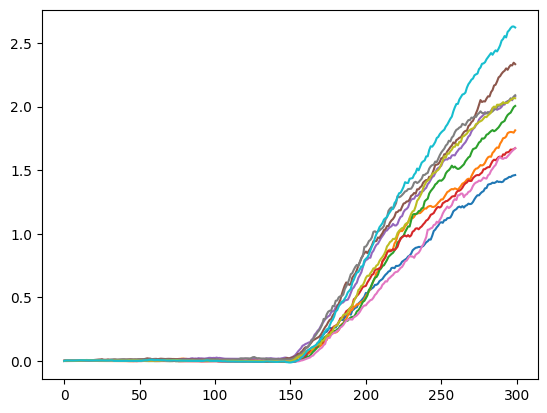

In [6]:
# final 
S = train_params([1.5,], [1e-2])
plt.plot(S.T)
plt.show()

### Score-based change point detector
quadratic $\Psi$, $\eta=1/\sqrt{t}$

In [9]:
def train_params(lambda_list, alpha_list, z=0):
    n = 300
    tau = 150
    runs = 10
    sigma = 0.2
    eta = 1 / np.sqrt(np.arange(1, n+1))
    dim = 1

    np.random.seed(3)
    for l in lambda_list:
        for a in alpha_list:
            # threshold 
            if z == 0:
                S_0 = np.empty(0)
                for item in range(10):
                    X = sigma * randn(size=tau).reshape((tau, dim, 1))                
                    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                    S, _ = model.run(X, eta, recalc=True)
                    S_0 = np.append(S_0, S)
                threshold = np.round(np.max(S_0), 4)
            else:
                threshold = z
            print('threshold = ', threshold)
            S_list = np.empty((runs, n))
            for item in range(runs):
                X = sigma * randn(size=n).reshape((n, dim, 1))      
                X[tau:] += 2*sigma          
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S

            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list

In [9]:


S = train_params([1], [4e-3])
S = train_params([1], [7e-3])
S = train_params([1], [1e-2])

S = train_params([1.1], [4e-3])
S = train_params([1.1], [7e-3])
S = train_params([1.1], [1e-2])

threshold =  2.9038
lambda = 1, alpha = 0.004  False alarms: 0 DD :  5.4 ± 3.0 not detected:  0
threshold =  2.887
lambda = 1, alpha = 0.007  False alarms: 0 DD :  5.7 ± 3.7 not detected:  0
threshold =  2.8701
lambda = 1, alpha = 0.01  False alarms: 0 DD :  5.8 ± 3.6 not detected:  0
threshold =  2.2983
lambda = 1.1, alpha = 0.004  False alarms: 0 DD :  5.7 ± 3.7 not detected:  0
threshold =  2.284
lambda = 1.1, alpha = 0.007  False alarms: 0 DD :  5.8 ± 3.5 not detected:  0
threshold =  2.2696
lambda = 1.1, alpha = 0.01  False alarms: 0 DD :  6.0 ± 3.5 not detected:  0


In [10]:
S = train_params([1], [1e-4])
S = train_params([1], [7e-4])
S = train_params([1], [1e-3])

S = train_params([1.1], [1e-4])
S = train_params([1.1], [7e-4])
S = train_params([1.1], [1e-3])

S = train_params([1.2], [1e-4])
S = train_params([1.2], [7e-4])
S = train_params([1.2], [1e-3])

threshold =  2.9257
lambda = 1, alpha = 0.0001  False alarms: 0 DD :  8.1 ± 3.8 not detected:  0
threshold =  2.9223
lambda = 1, alpha = 0.0007  False alarms: 0 DD :  6.3 ± 3.8 not detected:  0
threshold =  2.9207
lambda = 1, alpha = 0.001  False alarms: 0 DD :  6.1 ± 3.8 not detected:  0
threshold =  2.317
lambda = 1.1, alpha = 0.0001  False alarms: 0 DD :  9.4 ± 4.1 not detected:  0
threshold =  2.3141
lambda = 1.1, alpha = 0.0007  False alarms: 0 DD :  6.3 ± 3.8 not detected:  0
threshold =  2.3127
lambda = 1.1, alpha = 0.001  False alarms: 0 DD :  6.3 ± 3.8 not detected:  0
threshold =  1.8788
lambda = 1.2, alpha = 0.0001  False alarms: 0 DD :  11.4 ± 6.1 not detected:  0
threshold =  1.8763
lambda = 1.2, alpha = 0.0007  False alarms: 0 DD :  6.7 ± 4.0 not detected:  0
threshold =  1.875
lambda = 1.2, alpha = 0.001  False alarms: 0 DD :  6.4 ± 3.7 not detected:  0


threshold =  2.9038
lambda = 1, alpha = 0.004  False alarms: 0 DD :  5.4 ± 3.0 not detected:  0


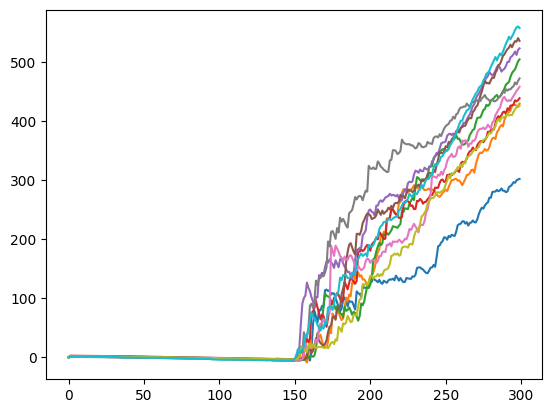

In [10]:
# final
S = train_params([1], [4e-3])
plt.plot(S.T)
plt.show()

## Univariate variance shift 

### Score-based change point detector
quadratic $\Psi$, $\eta=1/\sqrt{t}$

In [31]:
def train_params(lambda_list, alpha_list):
    n = 160
    tau = 150
    runs = 10
    sigma1 = 0.1
    sigma2 = 0.3
    eta = 1 / np.sqrt(np.arange(1, n+1))
    dim = 1

    np.random.seed(1)
    for l in lambda_list:
        for a in alpha_list:
            # threshold 
            S_0 = np.empty(0)
            for item in range(10):
                X = randn(size=tau).reshape((tau, dim, 1)) * sigma1               
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_0 = np.append(S_0, S)
            z = np.max(S_0)
            print('threshold = ', z)


            S_list = np.empty((runs, n))
            for item in range(runs):
                X = randn(size=n).reshape((n, dim, 1))      
                X[:tau] *= sigma1
                X[tau:] *= sigma2   
                model = ChangePointDetector(d_dim=dim*2,x_dim=dim,  lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S
            
            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, z, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list

In [32]:
for a in [1e-5, 1e-4, 1e-3, 1e-2]:
    for l in [0.5, 0.8, 1, 1.2, 1.5]:
        S = train_params([l], [a])


threshold =  20.10935642746057
1 2
1 7
1 8
lambda = 0.5, alpha = 1e-05  False alarms: 3 DD :  3.4 ± 2.4 not detected:  0
threshold =  5.3192362248603935
lambda = 0.8, alpha = 1e-05  False alarms: 0 DD :  4.8 ± 2.5 not detected:  1
threshold =  2.99720554363715
lambda = 1, alpha = 1e-05  False alarms: 0 DD :  5.6 ± 1.9 not detected:  2
threshold =  1.9137137483258506
lambda = 1.2, alpha = 1e-05  False alarms: 0 DD :  5.4 ± 2.1 not detected:  5
threshold =  1.1268540213328546
lambda = 1.5, alpha = 1e-05  False alarms: 0 DD :  6.2 ± 2.7 not detected:  4
threshold =  20.10711137068879
1 2
1 7
1 8
lambda = 0.5, alpha = 0.0001  False alarms: 3 DD :  3.4 ± 2.4 not detected:  0
threshold =  5.318447537510478
lambda = 0.8, alpha = 0.0001  False alarms: 0 DD :  4.2 ± 2.6 not detected:  0
threshold =  2.9966849365608472
lambda = 1, alpha = 0.0001  False alarms: 0 DD :  4.9 ± 2.0 not detected:  2
threshold =  1.913331468858103
lambda = 1.2, alpha = 0.0001  False alarms: 0 DD :  5.6 ± 1.9 not detec

In [33]:
S = train_params([0.8], [1e-4])

threshold =  5.318447537510478
lambda = 0.8, alpha = 0.0001  False alarms: 0 DD :  4.2 ± 2.6 not detected:  0


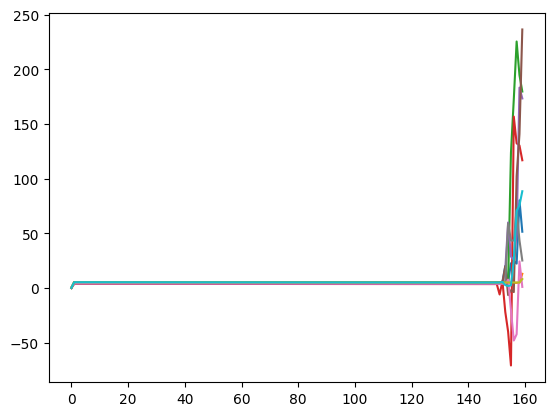

In [41]:
plt.plot(S.T)
plt.show()

## Multivariate mean shift

### Score-based change point detector
linear $\Psi$, $\eta=1/\sqrt{t}$

In [22]:



dim = 3
mean = np.zeros(dim)
cov = np.eye(dim)
n=170
tau = 150


def train_params(lambda_list, alpha_list, sigma, thrs_add=0, runs=10):
    eta = 1/np.sqrt(np.arange(1, n+1))

    np.random.seed(1)
    for l in lambda_list:
        for a in alpha_list:
            
            # threshold 
            S_0 = np.empty((9, tau))
            for item in range(9):
                X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma[None, :, None]       
                model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                S, _ = model.run(X, eta, recalc=True)
                S_0[item] = S
                
            threshold = np.max(S_0) + thrs_add
            print('threshold = ', threshold)


            S_list = np.empty((runs, n))
            for item in range(runs):
                X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma[None, :, None]         
                X[tau:] += 3*sigma[:, None]
                model = ChangePointDetector(d_dim=dim, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(1, dim), reference_score=reference_score)
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S

            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


In [19]:
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([0.5, 0.8, 1.2], [1e-5, 1e-4, 4e-3, 1e-2], sigma=sigma)
S = train_params([1, 3, 5], [4e-3, 1e-2], sigma=sigma)

threshold =  0.09025336561040559
lambda = 0.5, alpha = 0.0  False alarms: 0 DD :  0 ± 0 not detected:  10
threshold =  0.08085604446216405
lambda = 0.5, alpha = 0.0001  False alarms: 0 DD :  77.6 ± 34.3 not detected:  1
threshold =  0.13212183023546492
32 5
lambda = 0.5, alpha = 0.004  False alarms: 1 DD :  12.2 ± 2.3 not detected:  0
threshold =  0.19948475128117032
lambda = 0.5, alpha = 0.01  False alarms: 0 DD :  8.6 ± 1.3 not detected:  0
threshold =  0.13861423990670022
lambda = 0.8, alpha = 0.0  False alarms: 0 DD :  0 ± 0 not detected:  10
threshold =  0.07005507425884142
lambda = 0.8, alpha = 0.0001  False alarms: 0 DD :  57.8 ± 14.3 not detected:  0
threshold =  0.11286904583068669
lambda = 0.8, alpha = 0.004  False alarms: 0 DD :  10.1 ± 1.6 not detected:  0
threshold =  0.12084765706763423
lambda = 0.8, alpha = 0.01  False alarms: 0 DD :  6.2 ± 1.4 not detected:  0
threshold =  0.026063339636351684
lambda = 1.2, alpha = 0.0  False alarms: 0 DD :  73.0 ± 41.6 not detected:  4

threshold =  0.1554273142205564
lambda = 1.1, alpha = 0.01  False alarms: 0 DD :  6.7 ± 1.7 not detected:  0


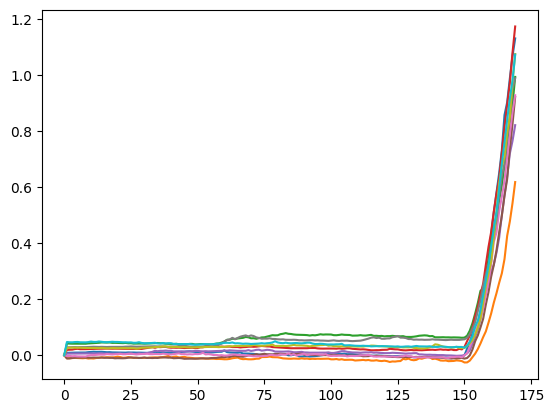

In [23]:
# final
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([1.1], [1e-2], sigma=sigma)
plt.plot(S.T)
plt.show()


### Score-based change point detector
quadratic $\Psi$, $\eta=1/\sqrt{t}$

In [17]:
# quadratic
dim = 3
mean = np.zeros(dim)
cov = np.eye(dim)
n=170
tau = 150


def train_params(lambda_list, alpha_list, sigma, thrs_add=0, runs=10):
    eta = 1/np.sqrt(np.arange(1, n+1))

    np.random.seed(1)
    for l in lambda_list:
        for a in alpha_list:
            
            # threshold 
            S_0 = np.empty((runs-1, tau))
            for item in range(runs-1):
                X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma[None, :, None]       
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_0[item] = S
                
            threshold = np.max(S_0) + thrs_add
            print('threshold = ', threshold)

            
            S_list = np.empty((runs, n))
            for item in range(runs):
                X = randmn(mean, cov, size=n).reshape((n, dim, 1)) * sigma[None, :, None]         
                X[tau:] += 3*sigma[:, None]
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S
            
            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 5)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


In [3]:
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([0.5], [1e-5, 1e-4, 1e-3, 1e-2], sigma=sigma, thrs_add = 0, runs=10)
S = train_params([1], [1e-5, 1e-4, 1e-3, 1e-2], sigma=sigma, thrs_add = 0, runs=10)

threshold =  0.0
1 1
1 3
lambda = 0.5, alpha = 0.0  False alarms: 2 DD :  58.3 ± 50.4 not detected:  5
threshold =  0.0
1 5
lambda = 0.5, alpha = 0.0001  False alarms: 1 DD :  46.7 ± 41.4 not detected:  3
threshold =  809.5403987743283
lambda = 0.5, alpha = 0.001  False alarms: 0 DD :  28.7 ± 33.5 not detected:  4
threshold =  61.69480120769066
lambda = 0.5, alpha = 0.01  False alarms: 0 DD :  60.6 ± 62.2 not detected:  5
threshold =  34.78693569185183
1 0
1 1
1 3
1 7
1 9
lambda = 1, alpha = 0.0  False alarms: 5 DD :  1.6 ± 0.5 not detected:  0
threshold =  50.13988992613659
1 9
lambda = 1, alpha = 0.0001  False alarms: 1 DD :  2.0 ± 0.8 not detected:  0
threshold =  61.761710926630016
lambda = 1, alpha = 0.001  False alarms: 0 DD :  1.9 ± 1.1 not detected:  0
threshold =  40.88149664365921
1 4
1 5
lambda = 1, alpha = 0.01  False alarms: 2 DD :  2.1 ± 0.8 not detected:  0



threshold =  41.62904095500973
lambda = 1, alpha = 1e-05  False alarms: 0 DD :  2.1 ± 0.9 not detected:  0


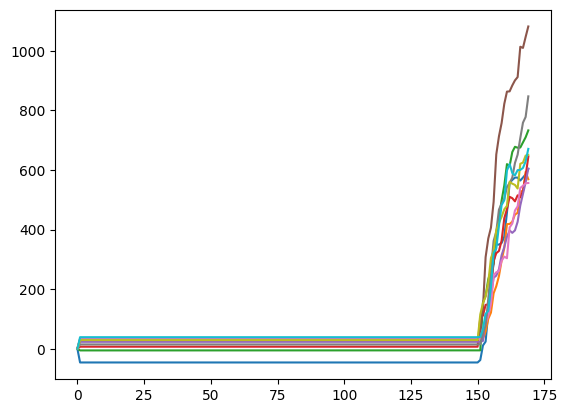

In [18]:
# final
sigma = np.array([0.1, 0.2, 0.3])
S = train_params([1], [1e-5], sigma=sigma)
plt.plot(S.T)
plt.show()


##  Multivariate variance shift

### Score-based change point detector
quadratic $\Psi$, $\eta=1/\sqrt{t}$

In [6]:
# quadratic
dim = 3
mean = np.zeros(dim)
cov = np.eye(dim)
n=300
tau = 150


def train_params(lambda_list, alpha_list, sigma1, sigma2, thrs_add=0, runs=10):
    eta = 1/np.sqrt(np.arange(1, n+1))

    np.random.seed(2)
    for l in lambda_list:
        for a in alpha_list:
            
            # threshold 
            S_0 = np.empty((runs-1, tau))
            for item in range(runs-1):
                X = randmn(mean, cov, size=tau).reshape((tau, dim, 1)) * sigma1[None, :, None]       
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_0[item] = S
                
            threshold = np.max(S_0) + thrs_add
            print('threshold = ', threshold)

            
            S_list = np.empty((runs, n))
            for item in range(runs):
                X = randmn(mean, cov, size=n).reshape((n, dim, 1))     
                X[:tau] *= sigma1[None, :, None]       
                X[tau:] *= sigma2[None, :, None]           
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(X, eta, recalc=True)
                S_list[item] = S
            
            false_alarms, mean_delay, std_delay, not_detected = compute_delays_false_alarms(runs, S_list, threshold, tau)
            print(f'lambda = {np.round(l, 4)}, alpha = {np.round(a, 4)}', ' False alarms:', false_alarms, 'DD : ', mean_delay, '±', std_delay, 'not detected: ', not_detected)
    return S_list


In [2]:
sigma1 = np.array([0.1, 0.2, 0.3])
sigma2 = np.array([0.3, 0.6, 0.9])

S = train_params([1], [1e-5], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1], [1e-4], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1], [1e-3], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1.1], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1.2], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1.4], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1.4], [1e-3], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
S = train_params([1.5], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)


threshold =  61.29235846306619
lambda = 1, alpha = 0.0  False alarms: 0 DD :  7.5 ± 3.5 not detected:  0
threshold =  61.28631255866409
lambda = 1, alpha = 0.0001  False alarms: 0 DD :  6.8 ± 4.1 not detected:  0
threshold =  61.225851305160276
lambda = 1, alpha = 0.001  False alarms: 0 DD :  5.7 ± 3.5 not detected:  0
threshold =  60.62101782181948
lambda = 1, alpha = 0.01  False alarms: 0 DD :  5.7 ± 3.7 not detected:  0
threshold =  43.725023067110506
lambda = 1.1, alpha = 0.01  False alarms: 0 DD :  5.4 ± 3.2 not detected:  0
threshold =  32.84035834478526
lambda = 1.2, alpha = 0.01  False alarms: 0 DD :  5.5 ± 3.2 not detected:  0
threshold =  20.289139350300378
lambda = 1.4, alpha = 0.01  False alarms: 0 DD :  5.5 ± 3.0 not detected:  0
threshold =  20.524898633850817
lambda = 1.4, alpha = 0.001  False alarms: 0 DD :  6.8 ± 4.2 not detected:  0
threshold =  16.511368231945855
lambda = 1.5, alpha = 0.01  False alarms: 0 DD :  5.7 ± 3.1 not detected:  0


threshold =  25.476227977027477
lambda = 1.3, alpha = 0.01  False alarms: 0 DD :  5.4 ± 3.0 not detected:  0


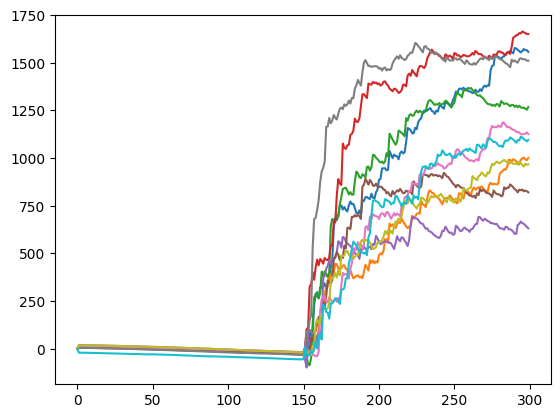

In [13]:

S = train_params([1.3], [1e-2], sigma1=sigma1, sigma2=sigma2, thrs_add = 0, runs=10)
plt.plot(S.T)
plt.show() 